# Курсовой проект для курса "Python для Data Science".

**Оглавление**
* [1. Постановка задачи](#intro)
* [2. Получение данных](#load)
* [3. Анализ данных](#analysis)
    * [Тренировочный датасет](#analysis_train)
    * [Тестовый датасет](#analysis_test)
* [4. Подготовка данных](#preprocess)
    * [Тренировочный датасет](#preprocess_train)
    * [Тестовый датасет](#preprocess_test) 
* [5. Генерация новых признаков](#new_features)
* [6. Уменьшение объема памяти, который занимает датасет](#reduce)
* [7. Разбиение на train / valid](#split)
* [8. Построение моделей](#model)
* [9. Обучение финальной модели](#final)
* [10. Применение модели к тестовому датасету](#pred)

## 1. Постановка задачи. <a class='anchor' id='intro'>

### Описание задачи:

- Используя данные из обучающего датасета, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели, предсказать цены для квартир из тестового датасета.

### Цель:
- Предсказать стоимость квартиры.
- Целевая переменная:
    Price.

### Зачем?

##### В банках, страховых компаниях:

- Узнать истинную стоимость имущества (залога)
- Принять решение о выдаче ипотеки/страховки
- Принять решение о % по ипотеке/страховке

##### На площадках объявлений (Авито, Циан, ...):

- Найти недооцененные квартиры (~ выгодные предложения), показать их пользователям
- Показывать рыночную стоимость квартиры пользователям
- Для тех, кто продает квартиру, рекомендовать цену продажи

##### Для инвесторов в недвижимость:

- Определять рыночную стоимость квартир
- Поиск недооцененных активов
- Торговля на рынке недвижимости

### Требование к решению:
- Метрика качества: r2 - коэффициент детерминации.

- r2 > 0.6.

## 2. Получение данных. <a class='anchor' id='load'>

Подключаем необходимые библиотеки и скрипты.

In [1]:
# Основные библиотеки
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm

# Метрика
from sklearn.metrics import r2_score

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams.update({'font.size': 14})

Пути к директориям и файлам.

In [4]:
DATA_TRAIN = './train.csv'
DATA_TRAIN_PREPARED = './train_prepared.csv'
DATA_TEST = './test.csv'
DATA_TEST_PREPARED = './test_prepared.csv'
PREDICTIONS = './AMeleshko_predictions.csv'

In [5]:
flats_train = pd.read_csv(DATA_TRAIN)
flats_test = pd.read_csv(DATA_TEST)

display(flats_train.head(), flats_train.shape, flats_test.head(), flats_test.shape)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


(10000, 20)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


(5000, 19)

## 3. Анализ данных. <a class='anchor' id='analysis'>

**Описание датасета:**

- **Id** - идентификационный номер квартиры
- **DistrictId** - идентификационный номер района
- **Rooms** - количество комнат
- **Square** - площадь
- **LifeSquare** - жилая площадь
- **KitchenSquare** - площадь кухни
- **Floor** - этаж
- **HouseFloor** - количество этажей в доме
- **HouseYear** - год постройки дома
- **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
- **Social_1, Social_2, Social_3** - социальные показатели местности
- **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
- **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
- **Price** - цена квартиры (целевой признак)

### Выведем информацию о данных.

In [6]:
def quantity_info(df):
    display(df.dtypes.value_counts())
    display(df.describe())
    
def category_info(df):
    obj_df = df.select_dtypes(include='object')
    result = pd.DataFrame()
    for col in obj_df.columns:
        result['values'] = (obj_df[col].value_counts())
        result['percent'] = round(df.groupby(col).size() / len(df) * 100, 2)
        display(col, result)

**Тренировочный датасет** <a class='anchor' id='analysis_train'>

* #### Количественные признаки

In [7]:
quantity_info(flats_train)

int64      9
float64    8
object     3
dtype: int64

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


В таблице 20 столбцов - признаки и 10000 строк - наблюдения. 

* **Id и DistrictId** - столбцы с Id района и квартиры. Тут аномалий и пропусков нет. Для обучения модели столбец **'Id'** не нужен.
* **Rooms** - есть аномальные значения min = 0 max = 19. Необходимо исследовать.
* **Square, LiveSquare, KitchenSquare** - так же минимальное и максимальное значения требуют анализа и обработки. В столбце **'LiveSquare'** есть пропуски, необходимо их заполнить.
* **Floor** - аномалий и пропусков нет.
* **HouseFloor** - необходимо изучить максимальные значения этажей.
* **HouseYear** - так же  изучить максимальные значения.
* **Остальные признаки** - относятся к показателям районов, их аномалии оценить сложно. В столбце **Healthcare_1** необходимо заполнить пропуски.


* #### Категориальные признаки

In [8]:
category_info(flats_train)

'Ecology_2'

,values,percent
B,9903,99.03
A,97,0.97


'Ecology_3'

,values,percent
B,9725,97.25
A,275,2.75


'Shops_2'

,values,percent
B,9175,91.75
A,825,8.25


* Все столбцы с бинарными данными. Есть большой перекос в сторону одних значений. Требуется перевод к численным значениям для обучения модели.

**Тестовый датасет** <a class='anchor' id='analysis_test'>

* #### Количественные признаки

In [9]:
quantity_info(flats_test)

int64      9
float64    7
object     3
dtype: int64

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


* В тестовом датасете те же аномалии, что  и тренировочном.

* #### Категориальные признаки

In [10]:
category_info(flats_test)

'Ecology_2'

,values,percent
B,4952,99.04
A,48,0.96


'Ecology_3'

,values,percent
B,4851,97.02
A,149,2.98


'Shops_2'

,values,percent
B,4588,91.76
A,412,8.24


* Соотношения признаков такие же, как и в тренировочных данных.

* #### Распределение целевой переменной в тренировочном датасете.

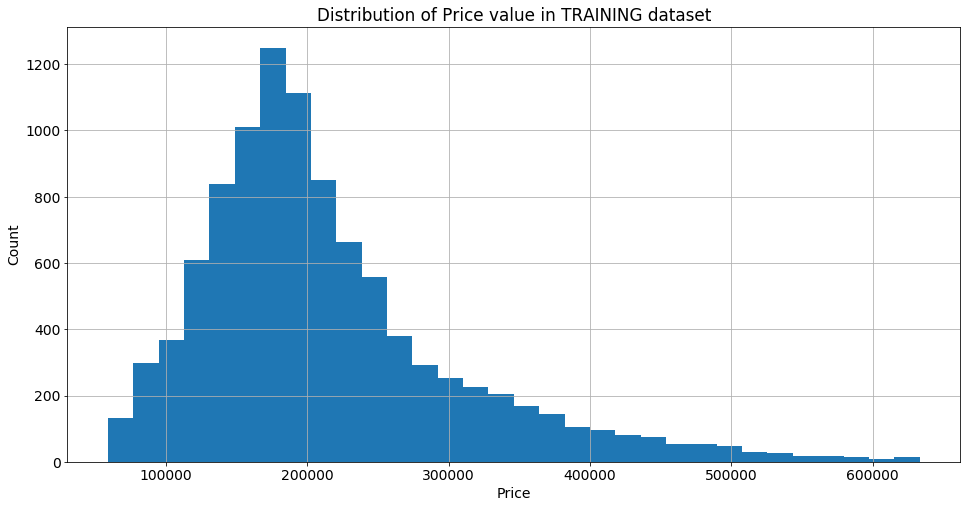

In [11]:
plt.figure(figsize = (16, 8))

flats_train['Price'].hist(bins=32)
plt.ylabel('Count', )
plt.xlabel('Price')

plt.title('Distribution of Price value in TRAINING dataset')
plt.show()

Распределение целевой переменной без явных аномалий.

## 4. Подготовка данных. <a class='anchor' id='preprocess'>

#### Функции

In [12]:
def square_normalize(df_, col):
    range1 = np.quantile(flats_train['Square'], q=0.005)
    range2 = np.quantile(flats_train['Square'], q=0.995)
    for i in range(1, 6):
        square_median = df_[df_['Rooms'] == i][col].median()
        crit_1 = df_['Rooms'] == i
        crit_2 = df_[col] < range1
        crit_3 = df_[col] > range2
        crit_4 = df_[col].isna()
        df_[col] = np.where((crit_1 & (crit_2 | crit_3 | crit_4)), square_median, df_[col])

In [13]:
def kitchen_normalize(df_, col):
    df_['kitchen_scale'] = df_[col] / df_['Square']
    max_square = np.quantile(df_['kitchen_scale'], q=0.99)
    for i in range(1, 6):
        square_median = df_[df_['Rooms'] == i][col].median()
        df_.loc[((df_['Rooms'] == i) & ((df_[col] == 0) | (df_['kitchen_scale'] >= max_square))), col] = square_median
    df_.drop('kitchen_scale', axis=1, inplace=True)

In [14]:
def life_normalize(df_):
    df_['square_diff'] = df_['Square'] - (df_['LifeSquare'] + df_['KitchenSquare'])
    for i in range(1, 6):
        diff_median = df_.loc[df_['Rooms'] == i]['square_diff'].median()
        df_.loc[((df_['Rooms'] == i) & (df_['square_diff'] < 0)), 'LifeSquare'] =\
        df_['Square'] - (df_['KitchenSquare'] + diff_median)
    df_.drop('square_diff', axis=1, inplace=True)

In [15]:
def floor_normalize(df_, col):
    df_[col] = np.where(((df_[col] == 0) |\
                         (df_[col] < df_['Floor']) |\
                         (df_[col] > df_['Floor'].max())),\
                         df_['Floor'], df_[col]
                       )

In [16]:
def binary_to_int(df_, col):
    list_ = list(df_[col].unique())
    df_.replace({col : { list_[0] : 0, list_[1] : 1}}, inplace=True)

**Тренировочный датасет** <a class='anchor' id='preprocess_train'>

* **'Rooms'**

In [17]:
display(flats_train['Rooms'].value_counts())

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Заменим выбросы на медиану.

In [18]:
flats_train.loc[((flats_train['Rooms'] == 0) | (flats_train['Rooms'] >= 6)), 'Rooms'] = flats_train['Rooms'].median()

display(flats_train['Rooms'].value_counts())

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

* **Square**

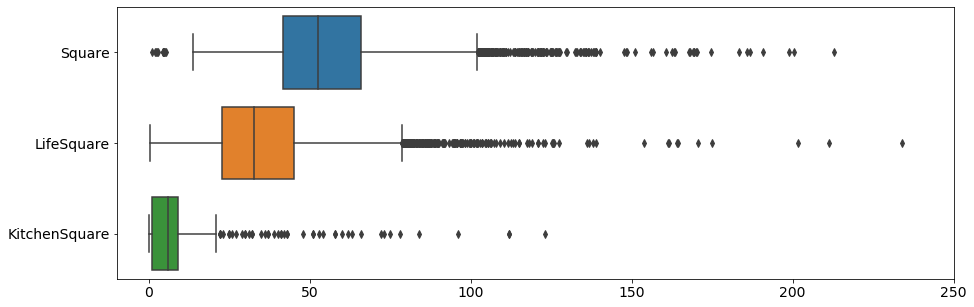

In [19]:
plt.figure(figsize=(15, 5))

sns.boxplot(data = flats_train[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xlim(-10, 250)
plt.show()

Убираем выбросы и приводим данные в порядок в столбцах с площадями.

In [20]:
square_normalize(flats_train, 'Square')

In [21]:
square_normalize(flats_train, 'LifeSquare')

In [22]:
kitchen_normalize(flats_train, 'KitchenSquare')

In [23]:
life_normalize(flats_train)

In [24]:
display(flats_train.describe())

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888400,55.921083,34.049642,6.084400,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.811056,17.681579,12.671374,3.545072,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,1.000000,27.245731,6.479630,1.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,21.663929,4.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.554849,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.870507,42.343231,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,5.000000,132.820646,114.913843,30.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


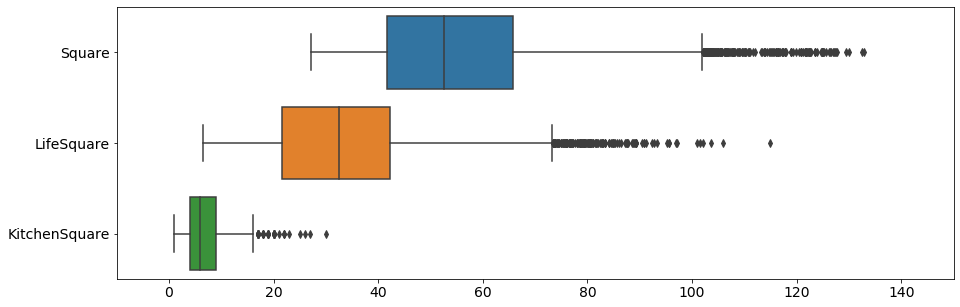

In [25]:
plt.figure(figsize=(15, 5))

sns.boxplot(data = flats_train[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xlim(-10, 150)
plt.show()

* **Floor**

In [26]:
display(flats_train['Floor'].sort_values().unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

В столбце с этажом квартиры аномалий и пропусков нет.

In [27]:
display(flats_train['HouseFloor'].sort_values().unique())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [28]:
display(len(flats_train.query('HouseFloor < Floor')))

1825

Есть аномальные значения: нулевые значения, слишком высокие значения этажности и значения этажности дома выше этажа квартиры.

Нормализуем данные.

In [29]:
floor_normalize(flats_train, 'HouseFloor')

* **HouseYear**

In [30]:
display(flats_train['HouseYear'].sort_values().unique())

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

Есть два аномальных значения. Исправим их.

In [31]:
flats_train.replace({'HouseYear' : { 4968 : 1968, 20052011 : 2011}}, inplace=True)

* **Healthcare_1**

In [32]:
display(flats_train['Healthcare_1'].isna().sum())

4798

Заполним пропуски.

In [33]:
flats_train.update(flats_train.sort_values(by=['DistrictId', 'Helthcare_2']).fillna(method ='ffill'))

In [34]:
display(flats_train['Healthcare_1'].describe())

count    10000.000000
mean      1053.928000
std        989.849293
min          0.000000
25%        262.000000
50%        800.000000
75%       1406.000000
max       4849.000000
Name: Healthcare_1, dtype: float64

* **Бинарные признаки**

In [35]:
col_list = ['Ecology_2', 'Ecology_3', 'Shops_2']
for col in col_list:
    binary_to_int(flats_train, col)
    print(f'{col}\n{flats_train[col].value_counts()}\n')

Ecology_2
0    9903
1      97
Name: Ecology_2, dtype: int64

Ecology_3
0    9725
1     275
Name: Ecology_3, dtype: int64

Shops_2
0    9175
1     825
Name: Shops_2, dtype: int64



**Тестовый датасет** <a class='anchor' id='preprocess_test'>

Исправим данные по анологии с тренировочным датасетом.

* **'Rooms'**

In [36]:
display(flats_test['Rooms'].value_counts())

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

Заменим выбросы на медиану.

In [37]:
flats_test.loc[((flats_test['Rooms'] == 0) | (flats_test['Rooms'] >= 6)), 'Rooms'] = flats_test['Rooms'].median()

display(flats_test['Rooms'].value_counts())

2.0    2035
1.0    1769
3.0    1099
4.0      90
5.0       7
Name: Rooms, dtype: int64

* **Square**

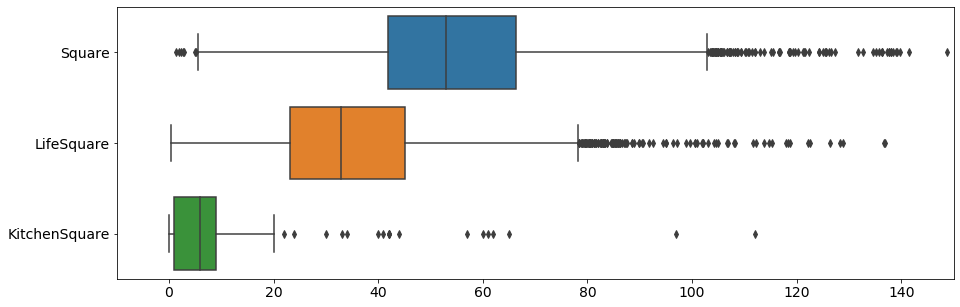

In [38]:
plt.figure(figsize=(15, 5))

sns.boxplot(data = flats_test[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xlim(-10, 150)
plt.show()

Убираем выбросы и приводим данные в порядок в столбцах с площадями.

In [39]:
square_normalize(flats_test, 'Square')

In [40]:
square_normalize(flats_test, 'LifeSquare')

In [41]:
kitchen_normalize(flats_test, 'KitchenSquare')

In [42]:
life_normalize(flats_test)

In [43]:
display(flats_test.describe())

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.906200,56.080802,34.249106,6.07420,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.805935,17.126437,12.363941,3.45495,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,1.000000,29.744373,11.228718,1.00000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.888568,21.802247,5.00000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.879195,32.832574,6.00000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.242386,42.389453,9.00000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,5.000000,120.330727,115.328430,22.00000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


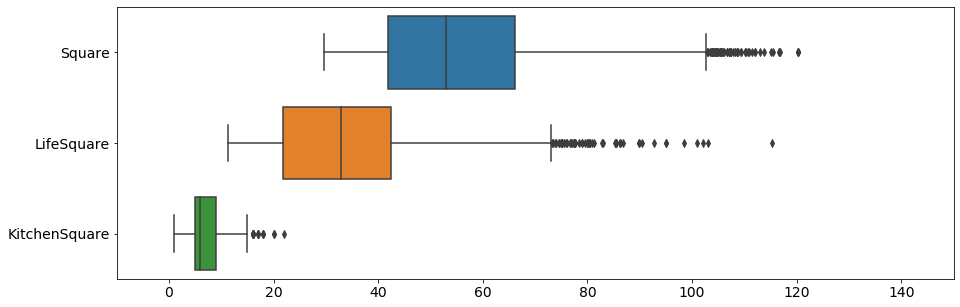

In [44]:
plt.figure(figsize=(15, 5))

sns.boxplot(data = flats_test[['Square', 'LifeSquare', 'KitchenSquare']], orient='h')
plt.xlim(-10, 150)
plt.show()

* **Floor**

In [45]:
display(flats_test['Floor'].sort_values().unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

В столбце с этажом квартиры есть аномальное значение 78. Заменим его на значение 18. Предположим, что вместо 1 написали 7.

In [46]:
flats_test.replace({'Floor' : { 78 : 18}}, inplace=True)

In [47]:
display(flats_test['HouseFloor'].sort_values().unique())

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [48]:
display(len(flats_test.query('HouseFloor < Floor')))

883

Есть аномальные значения: нулевые значения, слишком высокие значения этажности и значения этажности дома выше этажа квартиры.

Нормализуем данные.

In [49]:
floor_normalize(flats_test, 'HouseFloor')

* **HouseYear**

In [50]:
display(flats_test['HouseYear'].sort_values().unique())

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

Данные в порядке.

* **Healthcare_1**

In [51]:
display(flats_test['Healthcare_1'].isna().sum())

2377

Заполним пропуски.

In [52]:
flats_test.update(flats_train.sort_values(by=['DistrictId', 'Helthcare_2']).fillna(method ='ffill'))

In [53]:
display(flats_test['Healthcare_1'].describe())

count    5000.00000
mean     1084.98060
std       994.01827
min        30.00000
25%       262.00000
50%       805.00000
75%      1406.00000
max      4849.00000
Name: Healthcare_1, dtype: float64

* **Бинарные признаки**

In [54]:
col_list = ['Ecology_2', 'Ecology_3', 'Shops_2']
for col in col_list:
    binary_to_int(flats_test, col)
    print(f'{col}\n{flats_test[col].value_counts()}\n')

Ecology_2
0    4954
1      46
Name: Ecology_2, dtype: int64

Ecology_3
0    4861
1     139
Name: Ecology_3, dtype: int64

Shops_2
0    4576
1     424
Name: Shops_2, dtype: int64



## 5. Генерация новых признаков. <a class='anchor' id='new_features'>

* **Разница в площади квартиры по отношению к подобным по числу комнат в конкретном районе**

In [55]:
flats_train['square_diff_and_mean_by_ditr&rooms'] = flats_train.groupby(['DistrictId', 'Rooms'])['Square'].apply(lambda x: x - x.mean())

flats_train['bigger_then_mean'] = np.where(flats_train['square_diff_and_mean_by_ditr&rooms'] > 0, 1, 0)

flats_train.drop('square_diff_and_mean_by_ditr&rooms', axis=1, inplace=True)

In [56]:
display(flats_train.head())

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,bigger_then_mean
0,14038,35,2.0,47.981561,32.554849,6.0,7,9.0,1969,0.089040,...,0,33,7976,5,800.0,0,11,0,184966.930730,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,0,46,10309,1,240.0,1,16,0,300009.450063,0
2,4765,53,2.0,44.947953,32.554849,6.0,8,12.0,1968,0.049637,...,0,34,7759,0,229.0,1,3,0,220925.908524,0
3,5809,58,2.0,53.352981,31.817438,9.0,8,17.0,1977,0.437885,...,0,23,5735,3,1084.0,0,5,0,175616.227217,0
4,10783,99,1.0,39.649192,21.663929,7.0,11,12.0,1976,0.012339,...,0,35,5776,1,2078.0,2,4,0,150226.531644,1


In [57]:
flats_test['square_diff_and_mean_by_ditr&rooms'] = flats_test.groupby(['DistrictId', 'Rooms'])['Square'].apply(lambda x: x - x.mean())

flats_test['bigger_then_mean'] = np.where(flats_test['square_diff_and_mean_by_ditr&rooms'] > 0, 1, 0)

flats_test.drop('square_diff_and_mean_by_ditr&rooms', axis=1, inplace=True)

In [58]:
display(flats_test.head())

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,bigger_then_mean
0,14038,35,2.0,47.981561,32.554849,6.0,7,9.0,1969,0.089040,0,0,33,7976,5,800.0,0,11,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,0,0,46,10309,1,240.0,1,16,0,0
2,4765,53,2.0,44.947953,32.554849,6.0,8,12.0,1968,0.049637,0,0,34,7759,0,229.0,1,3,0,0
3,5809,58,2.0,53.352981,31.817438,9.0,8,17.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0,0
4,10783,99,1.0,39.649192,21.663929,7.0,11,12.0,1976,0.012339,0,0,35,5776,1,2078.0,2,4,0,1


* **Количество предложений по районам**

In [59]:
def ads_ratio(df_):    
    range_1 = df_['number_of_ad'].describe()['25%']
    range_2 = df_['number_of_ad'].describe()['75%']
    df_.loc[(df_['number_of_ad'] <= range_1), 'ads_category'] = 'few_ads'
    df_.loc[(df_['number_of_ad'] >= range_2), 'ads_category'] = 'many_ads'
    df_.loc[((df_['number_of_ad'] > range_1) & (df_['number_of_ad'] < range_2)), 'ads_category'] = 'normally_ads'

In [60]:
number_of_ad = flats_train['DistrictId'].value_counts().reset_index()\
            .rename(columns = {'index': 'DistrictId', 'DistrictId': 'number_of_ad'})

In [61]:
flats_train = flats_train.merge(number_of_ad, on='DistrictId', how='left')

In [62]:
ads_ratio(flats_train)

In [63]:
flats_train = pd.concat([flats_train, pd.get_dummies(flats_train['ads_category'], drop_first=True)], axis=1)

In [64]:
display(flats_train.head())

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,bigger_then_mean,number_of_ad,ads_category,many_ads,normally_ads
0,14038,35,2.0,47.981561,32.554849,6.0,7,9.0,1969,0.089040,...,800.0,0,11,0,184966.930730,0,22,few_ads,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,240.0,1,16,0,300009.450063,0,87,normally_ads,0,1
2,4765,53,2.0,44.947953,32.554849,6.0,8,12.0,1968,0.049637,...,229.0,1,3,0,220925.908524,0,174,normally_ads,0,1
3,5809,58,2.0,53.352981,31.817438,9.0,8,17.0,1977,0.437885,...,1084.0,0,5,0,175616.227217,0,179,normally_ads,0,1
4,10783,99,1.0,39.649192,21.663929,7.0,11,12.0,1976,0.012339,...,2078.0,2,4,0,150226.531644,1,97,normally_ads,0,1


In [65]:
number_of_ad = flats_test['DistrictId'].value_counts().reset_index()\
            .rename(columns = {'index': 'DistrictId', 'DistrictId': 'number_of_ad'})

In [66]:
flats_test = flats_test.merge(number_of_ad, on='DistrictId', how='left')

In [67]:
ads_ratio(flats_test)

In [68]:
flats_test = pd.concat([flats_test, pd.get_dummies(flats_test['ads_category'], drop_first=True)], axis=1)

In [69]:
display(flats_test.head())

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,bigger_then_mean,number_of_ad,ads_category,many_ads,normally_ads
0,14038,35,2.0,47.981561,32.554849,6.0,7,9.0,1969,0.089040,...,5,800.0,0,11,0,1,8,few_ads,0,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,0,0,39,normally_ads,0,1
2,4765,53,2.0,44.947953,32.554849,6.0,8,12.0,1968,0.049637,...,0,229.0,1,3,0,0,76,normally_ads,0,1
3,5809,58,2.0,53.352981,31.817438,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,0,0,85,normally_ads,0,1
4,10783,99,1.0,39.649192,21.663929,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,0,1,44,normally_ads,0,1


## 6. Уменьшение объема памяти, который занимает датасет <a class='anchor' id='reduce'>

In [70]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [71]:
reduce_mem_usage(flats_train)

Memory usage of dataframe is 1.81 MB
Memory usage after optimization is: 0.66 MB
Decreased by 63.7%


In [72]:
reduce_mem_usage(flats_test)

Memory usage of dataframe is 0.87 MB
Memory usage after optimization is: 0.31 MB
Decreased by 64.3%


* **Сохранение датасетов**

In [73]:
flats_train.to_csv(DATA_TRAIN_PREPARED, index=False, encoding='utf-8', sep=';')

In [74]:
flats_test.to_csv(DATA_TEST_PREPARED, index=False, encoding='utf-8', sep=';')

## 7. Разбиение на train / valid <a class='anchor' id='split'>

In [75]:
X = flats_train.drop(['Id', 'ads_category', 'Price'], axis = 1)

In [76]:
display(X.head(2))

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,bigger_then_mean,number_of_ad,many_ads,normally_ads
0,35,2.0,47.98156,32.554848,6.0,7,9.0,1969,0.08904,0,...,7976,5,800.0,0,11,0,0,22,0.0,0.0
1,41,3.0,65.68364,40.049541,8.0,7,9.0,1978,0.00007,0,...,10309,1,240.0,1,16,0,0,87,0.0,1.0


In [77]:
y = flats_train['Price']

In [78]:
display(y.head(2))

0    184966.9375
1    300009.4375
Name: Price, dtype: float32

In [79]:
X_test = flats_test.drop(['Id', 'ads_category'], axis = 1)

In [80]:
display(X_test.head(2))

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,bigger_then_mean,number_of_ad,many_ads,normally_ads
0,35,2.0,47.98156,32.554848,6.0,7,9.0,1969,0.08904,0,...,7976,5,800.0,0,11,0,1,8,0.0,0.0
1,41,3.0,65.68364,40.049541,8.0,7,9.0,1978,0.00007,0,...,10309,1,240.0,1,16,0,0,39,0.0,1.0


In [81]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=123)

In [82]:
display(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape )

(7500, 22)

(2500, 22)

(7500,)

(2500,)

## 8. Построение моделей <a class='anchor' id='model'>

In [83]:
lgbm_model = lightgbm.LGBMRegressor(n_estimators=250, class_weight='balanced', learning_rate=0.025, max_depth=8, random_state=123)
lgbm_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=1.0, importance_type='split',
              learning_rate=0.025, max_depth=8, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=250,
              n_jobs=-1, num_leaves=31, objective=None, random_state=123,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [84]:
lgbm_pred_train = lgbm_model.predict(X_train)

lgbm_pred_valid = lgbm_model.predict(X_valid)

In [85]:
display(r2_score(y_train, lgbm_pred_train))
display(r2_score(y_valid, lgbm_pred_valid))

0.8414339823624026

0.7545979724895451

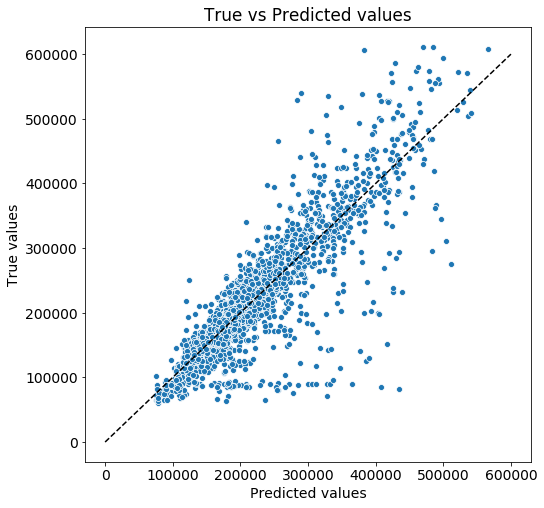

In [86]:
plt.figure(figsize=(8,8))

sns.scatterplot(x=lgbm_pred_valid, y=y_valid)
plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values

plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('True vs Predicted values')
plt.show()

## 9. Обучение финальной модели.  <a class='anchor' id='final'>

In [87]:
final_model = lightgbm.LGBMRegressor(n_estimators=250,
                                     class_weight='balanced',
                                     learning_rate=0.025,
                                     max_depth=8,
                                     random_state=123)

In [88]:
final_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=1.0, importance_type='split',
              learning_rate=0.025, max_depth=8, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=250,
              n_jobs=-1, num_leaves=31, objective=None, random_state=123,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

## 10. Применение модели к тестовому датасету <a class='anchor' id='pred'>

In [89]:
pred_test = pd.DataFrame(final_model.predict(X_test))

In [90]:
pred_test

,0
0,222149.259004
1,270411.979892
2,211430.148982
3,194255.882685
4,170650.748470
...,...
4995,446546.804808
4996,237273.766632
4997,152073.323725
4998,459399.980776


In [91]:
pred_test.to_csv(PREDICTIONS, index=False, encoding='utf-8', sep=';')